In [159]:
!pip install costcla

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 27.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyea: filename=pyea-0.2-py3-none-any.whl size=6001 sha256=3bd2f94cbf8f49be3e73f3cd0620bb33b16d9e4f5c556ff4c28760fc4d2f552a
  Stored in directory: /root/.cache/pip/wheels/8a/ae/37/49a4b22c960811c7fcec964b1d771848e1021e756a133f9bcd
Successfully built pyea


In [160]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib_inline.backend_inline

from itertools import accumulate

from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.metrics import confusion_matrix, classification_report, \
    f1_score, make_scorer, PrecisionRecallDisplay, RocCurveDisplay

from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.over_sampling import SMOTE, ADASYN, \
    RandomOverSampler as ROS
from imblearn.under_sampling import RandomUnderSampler as RUS, \
    CondensedNearestNeighbour as CNN, TomekLinks, \
    EditedNearestNeighbours as ENN

from scipy.spatial.distance import pdist, squareform

import sys
import joblib
import six
import sklearn.ensemble._base
sys.modules['sklearn.externals.joblib'] = joblib
sys.modules['sklearn.externals.six'] = six
sys.modules['sklearn.externals.six.moves'] = six.moves
sys.modules['sklearn.ensemble.base'] = sklearn.ensemble._base
from costcla.models import CostSensitiveDecisionTreeClassifier as CSDTC
from costcla.metrics import savings_score

In [3]:

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from collections import Counter

In [4]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib_inline.backend_inline

from itertools import accumulate

from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.metrics import confusion_matrix, classification_report, \
    f1_score, make_scorer, PrecisionRecallDisplay, RocCurveDisplay

from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.over_sampling import SMOTE, ADASYN, \
    RandomOverSampler as ROS
from imblearn.under_sampling import RandomUnderSampler as RUS, \
    CondensedNearestNeighbour as CNN, TomekLinks, \
    EditedNearestNeighbours as ENN

from scipy.spatial.distance import pdist, squareform

In [5]:
matplotlib_inline.backend_inline.set_matplotlib_formats('png', 'pdf')
plt.rcParams.update({'font.size': 12,
                     'xtick.labelsize' : 12,
                     'ytick.labelsize' : 12,
                     'axes.grid': False})

my_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [6]:
def plot_confusion_mtx(cm: 'confusion matrix', labels = None,
                       figsize = (3,3), binary = True):
    fig = plt.figure(figsize = figsize)
    ax = fig.add_subplot()
    sns.heatmap(cm, annot = True, fmt = '0', annot_kws = {"fontsize": 16},
                cmap = "Blues", cbar = False, ax = ax)
    ax.set_xlabel('Predicted Class', fontsize = 14)
    ax.set_ylabel('Actual Class', fontsize = 14)
    if labels is None:
        labels = range(1, cm.shape[1] + 1)
    ax.set_xticks(ax.get_xticks(), labels)
    ax.set_yticks(ax.get_yticks(), labels)
    if binary:
        ax.set_xticks([0.5,1.5], [r'+', r'$-$'], fontsize = 18)
        ax.set_yticks([0.5,1.5], [r'+', r'$-$'], fontsize = 18)
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top')

In [8]:
def plot_gains_curve(y_true:'np array', y_pred_proba:'np array',
                     label = None, baseline = False):
    idx = np.argsort(y_pred_proba)[::-1]
    acc = list(accumulate(y_true[idx]))
    plt.plot(acc, label = label)
    n_samples = len(acc)
    if baseline:
        plt.plot([0,n_samples], [0, acc[-1]], 'k--')

    xticks = np.linspace(0, n_samples, 6)
    yticks = np.linspace(0, acc[-1], 6)
    x_lab = np.around(np.linspace(0, 1, 6), decimals = 1)
    y_lab = np.around(np.linspace(0, 1, 6), decimals = 1)
    plt.xticks(xticks, x_lab)
    plt.yticks(yticks, y_lab)
    plt.xlabel('% of samples', fontsize = 14)
    plt.ylabel('Gain', fontsize = 14)

In [9]:
def plot_lift(y_true:'np array', y_pred_proba:'np array',
              label = None, baseline = False):
    n_samples = len(y_true)
    idx = np.argsort(y_pred_proba)[::-1]
    cum_trues = list(accumulate(y_true[idx]))
    perc_trues = map(lambda x: x / cum_trues[-1], cum_trues)
    cum_samples = range(1, n_samples + 1)
    perc_samples = map(lambda x: x / n_samples, cum_samples)
    lift = list(map(lambda x, y: x / y, perc_trues, perc_samples))
    plt.plot(lift, label = label)
    if baseline:
        plt.axhline(y = 1, ls = '--', color = 'k')
    plt.xlabel('% of samples', fontsize = 14)
    plt.ylabel('Lift', fontsize = 14)

In [10]:
def plot_decision_boundaries(X, classes, clf,
                             class_names: dict = None, figsize = (6, 4)):
    '''
    classes: array-like containing numerical classes
    clf: the trained classifier
    class_names: dict mapping class numbers to class names
    '''

    fig = plt.figure(figsize = figsize)
    ax = fig.add_subplot()
    x_min, y_min = X.min(axis = 0) - 1
    x_max, y_max = X.max(axis = 0) + 1
    '''
    artificial generated points evenly spaced within the region
    delimitated by our data. x_grid and y_grid are matrices
    containing x and y coordinates respectively.
    '''
    x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, 1000),
                                 np.linspace(y_min, y_max, 1000))
    # put together x and y coordinates to build a matrix of (x,y) points
    xy_coordinates = np.vstack((x_grid.ravel(), y_grid.ravel())).T
    # predictions of the artificial points
    pred = clf.predict(xy_coordinates) # 1d array with size=100_000
    # Plot decision boundary and scatter plot
    contourf = ax.contourf(x_grid, y_grid, pred.reshape(1000, 1000), alpha = 0.6)
    scatter = ax.scatter(X[:, 0], X[:, 1], c = classes, edgecolor = 'k')
    handles, labels = scatter.legend_elements()
    if class_names is not None:
        # each item in labels has the format '$\\mathdefault{number}$'
        keys = [int(''.join(filter(str.isdigit, string))) for string in labels]
        labels = [class_names[i] for i in keys]
    ax.legend(handles, labels, loc = 'lower center', ncol = 2,
              fontsize = 'small', bbox_to_anchor = (0, 1, 1, 1))
    ax.set_xlabel('1st Component', fontsize = 14)
    ax.set_ylabel('2nd Component', fontsize = 14)
    ax.set_xticks([])
    ax.set_yticks([])

In [117]:
def plot_scatter(X: 'reduced dataset', y: 'target variable',
                 class_names: dict = None, figsize = (6, 4), ax = None,
                 top_legend = True):
    '''
    class_names: dict mapping class numbers (y) to class names
    '''
    if ax is None:
        fig, ax = plt.subplots(figsize = figsize)
    scatter = ax.scatter(X[:, 0], X[:, 1], c = y, edgecolor = 'k', lw = 0.5)
    handles, labels = scatter.legend_elements()
    if class_names is not None:
        # each item in labels has the format '$\\mathdefault{number}$'
        keys = [int(''.join(filter(str.isdigit, string))) for string in labels]
        labels = [class_names[i] for i in keys]
    ax.set_xlabel('1st Component', fontsize = 14)
    ax.set_ylabel('2nd Component', fontsize = 14)
    ax.set_xticks([])
    ax.set_yticks([])
    if top_legend:
        ax.legend(handles, labels, loc = 'lower center', ncol = 2,
                  fontsize = 'small', bbox_to_anchor = (0, 1, 1, 1))
    else:
        ax.legend(handles, labels, fontsize = 'small',
                  loc = 'center left',  bbox_to_anchor = (1.04, 0.5), borderaxespad = 0)


## Data Preparation

In [69]:
# dataset with the 23 best variables selected during the feature analysis

X_train = pd.read_csv("X_train_no_red.csv", header = 0)
X_test = pd.read_csv("X_test_no_red.csv", header = 0)
y_train = pd.read_csv("y_train_wo_outliers_num.csv", header = None)[0]
y_test = pd.read_fwf("y_test.txt", header = None)[0]

In [70]:
X_train.columns = X_train.columns.astype(int)
X_test.columns = X_test.columns.astype(int)

In [71]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, sep = '\n')

(7352, 540)
(2947, 540)
(7274,)
(2947,)


In [72]:
with open("features.txt") as f:
    lines = f.read().splitlines()

features = {}
for line in lines:
    idx, name = line.split()
    features[int(idx)-1] = name

# features

In [73]:
with open('activity_labels.txt') as f:
    lines = f.read().splitlines()

activities = {}
for line in lines:
    label, activity = line.split()
    activities[int(label)] = activity

In [74]:
activities

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

In [75]:
y_train_mapped = y_train.map(activities)

## Imbalance the dataset

Since point 1.4 of the project guidelines impose to perform a BINARY classification, there are only two alternatives:

- 1) relabel the activities in movement and stationary activities end perform binary classification.
- 2) select two classes, unbalance one of them, and perform a binary classification;

but:
- 3) We can also try to perform a multiclass classification by unbalancing one or more classes.

### 2)

Let's try to perform a binary classification between WALKING UPSTAIRS and WALKING DOWNSTAIRS

In [76]:
# let's select WALKING UPSTAIRS and WALKING DOWNSTAIRS in the train set

mask = (y_train == 4) | (y_train == 5)
idx = y_train[mask].index
X2_train = X_train.loc[idx]
y2_train = y_train.loc[idx]

X2_train.shape, y2_train.shape

((2650, 540), (2650,))

In [77]:
generator = np.random.default_rng(seed = 5)

In [78]:
np.unique(y2_train, return_counts = True)

(array([4, 5]), array([1277, 1373]))

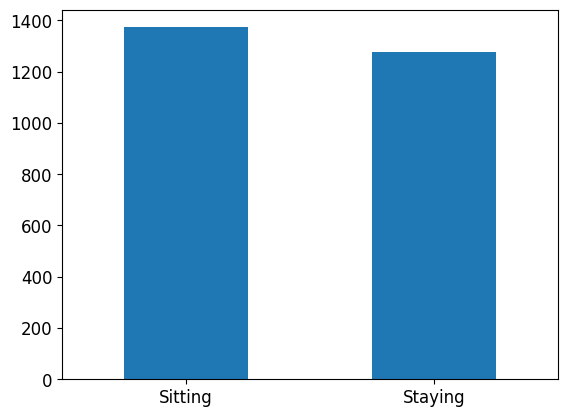

In [79]:
y2_train.value_counts().plot.bar(rot = 0)
ax = plt.gca()
xticks = ax.get_xticks()
plt.xticks(xticks, ['Sitting', 'Staying'])
plt.show()

In [80]:
np.unique(y2_train, return_counts = True)

(array([4, 5]), array([1277, 1373]))

The two classes are balanced

In [81]:
# let's select WALKING UPSTAIRS and WALKING DOWNSTAIRS in the test set

mask = (y_test == 4) | (y_test == 5)
idx = y_test[mask].index
X2_test = X_test.loc[idx]
y2_test = y_test.loc[idx]

X2_test.shape, y2_test.shape

((1023, 540), (1023,))

In [82]:
clf = DTC(random_state = 5).fit(X2_train, y2_train)
y_pred = clf.predict(X2_test)

In [83]:
clf.get_depth()

17

In [84]:
clf.get_n_leaves()

178

In [85]:
print(classification_report(y2_test, y_pred))

              precision    recall  f1-score   support

           4       0.55      0.90      0.68       491
           5       0.78      0.33      0.46       532

    accuracy                           0.60      1023
   macro avg       0.66      0.61      0.57      1023
weighted avg       0.67      0.60      0.57      1023



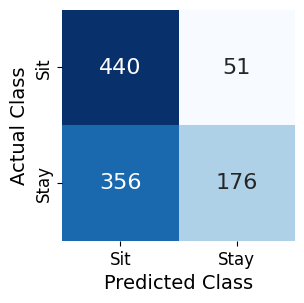

In [86]:
cm = confusion_matrix(y2_test, y_pred, labels = clf.classes_)
plot_confusion_mtx(cm, ['Sit', 'Stay'], binary = False)

The classifier has good performances though we built a full tree without tuning the hyperparameters. Now let's try to unbalance the WALKING DOWNSTAIRS class.

---

In [87]:
y2_train.value_counts()

5    1373
4    1277
Name: 0, dtype: int64

In [88]:
'''
In order to obtain a 96-4% proportion we need
to sample 44 SITTING instances
'''

walk_down_idx = y2_train[y2_train == 4].index
walk_up_idx = y2_train[y2_train == 5].index
sampled_idx = generator.choice(walk_down_idx, 41, replace = False)
mask = np.sort(np.hstack((sampled_idx, walk_up_idx)))
X2_train_imb = X2_train.loc[mask]
y2_train_imb = y2_train.loc[mask]

X2_train_imb.shape, y2_train_imb.shape

((1414, 540), (1414,))

In [89]:
np.unique(X2_train_imb, return_counts=True)

(array([-1.        , -0.99999999, -0.99999998, ...,  0.99985267,
         0.99999475,  1.        ]),
 array([6065,    5,    4, ...,    1,    1,  247]))

In [90]:
'''
relabel STAYING as 1 (positive class/minority class)
and SITTING as 0 since the grid search raise a label error
'''

y2_train_imb = y2_train_imb.map(lambda x: 1 if x == 5 else 0)
y2_test = y2_test.map(lambda x: 1 if x == 5 else 0)

print(y2_train_imb.value_counts(), y2_test.value_counts(), sep = '\n')

1    1373
0      41
Name: 0, dtype: int64
1    532
0    491
Name: 0, dtype: int64


In [91]:
y2_test

0       1
1       1
2       1
3       1
4       1
       ..
2818    0
2819    0
2820    0
2821    0
2822    0
Name: 0, Length: 1023, dtype: int64

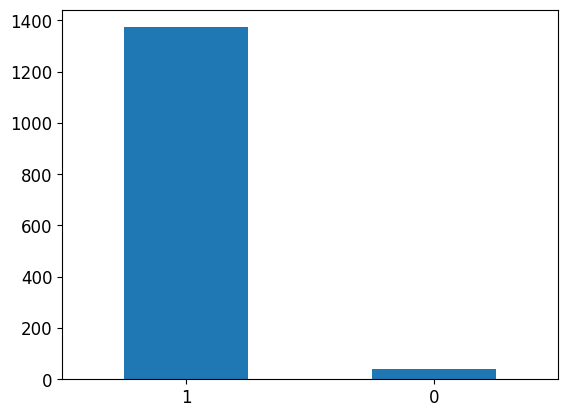

In [92]:
y2_train_imb.value_counts().plot.bar(rot = 0)
plt.show()

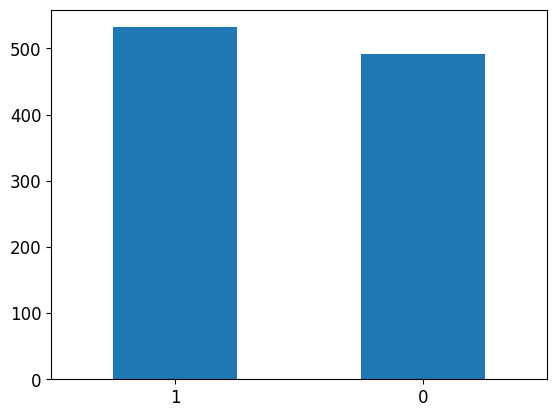

In [93]:
y2_test.value_counts().plot.bar(rot = 0)
plt.show()

In [39]:
# imbalance, w/o tuning

dtc = DTC(random_state = 5).fit(X2_train_imb, y2_train_imb)
y2_pred_imb = dtc.predict(X2_test)

In [40]:
dtc.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 5,
 'splitter': 'best'}

In [41]:
dtc.get_depth()

12

In [42]:
dtc.get_n_leaves()

24

In [43]:
print(classification_report(y2_test, y2_pred_imb))

              precision    recall  f1-score   support

           0       0.87      0.56      0.68       491
           1       0.70      0.92      0.79       532

    accuracy                           0.75      1023
   macro avg       0.78      0.74      0.74      1023
weighted avg       0.78      0.75      0.74      1023



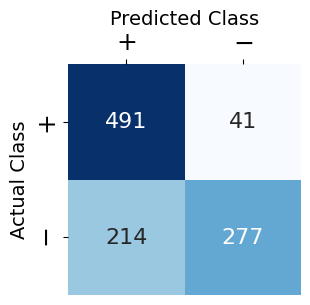

In [44]:
cm = confusion_matrix(y2_test, y2_pred_imb, labels = [1, 0])
plot_confusion_mtx(cm, [], binary = True)

Accuracy 0.6168132942326491
F1-score [0.39130435 0.72039943]
              precision    recall  f1-score   support

           0       0.82      0.26      0.39       491
           1       0.58      0.95      0.72       532

    accuracy                           0.62      1023
   macro avg       0.70      0.60      0.56      1023
weighted avg       0.70      0.62      0.56      1023



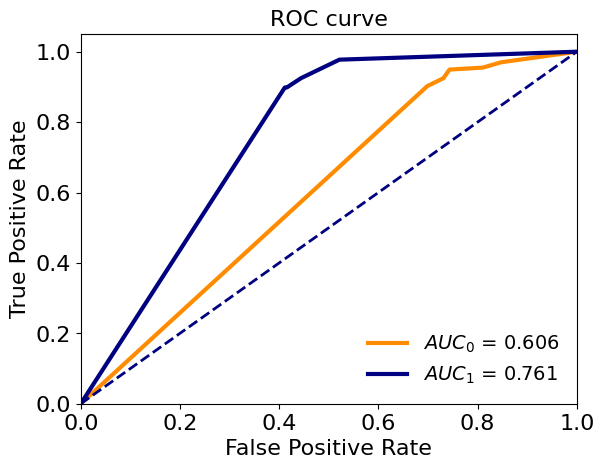

In [94]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X2_train_imb, y2_train_imb)

y2_pred_imb= clf.predict(X2_test)
print('Accuracy %s' % accuracy_score(y2_test, y2_pred_imb))
print('F1-score %s' % f1_score(y2_test, y2_pred_imb, average=None))
print(classification_report(y2_test, y2_pred_imb))

y_score = clf.predict_proba(X2_test)
fpr0, tpr0, _ = roc_curve(y2_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='navy', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

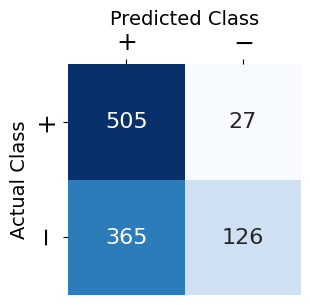

In [95]:
cm = confusion_matrix(y2_test, y2_pred_imb, labels = [1, 0])
plot_confusion_mtx(cm, [], binary = True)

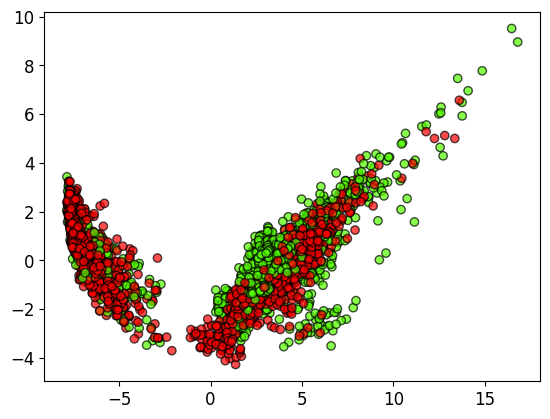

In [96]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X2_train)
X_pca = pca.transform(X2_train)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y2_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

## UNDERSAMPLING

### RANDOM UNDERSAMPLING

In [97]:
under = RUS(random_state = 5)
X2_under_res, y2_under_res = under.fit_resample(X2_train_imb, y2_train_imb)

In [98]:
np.unique(y2_under_res, return_counts = True)

(array([0, 1]), array([41, 41]))

The train set contains only 41 instances

In [99]:
dtc_under = DTC(random_state = 5).fit(X2_under_res, y2_under_res)

In [100]:
dtc_under.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 5,
 'splitter': 'best'}

In [101]:
dtc_under.get_depth()

4

In [102]:
dtc_under.get_n_leaves()

9

In [103]:
y2_pred_under = dtc_under.predict(X2_test)
print(classification_report(y2_test, y2_pred_under))

              precision    recall  f1-score   support

           0       0.52      0.64      0.57       491
           1       0.57      0.45      0.50       532

    accuracy                           0.54      1023
   macro avg       0.54      0.54      0.54      1023
weighted avg       0.55      0.54      0.53      1023



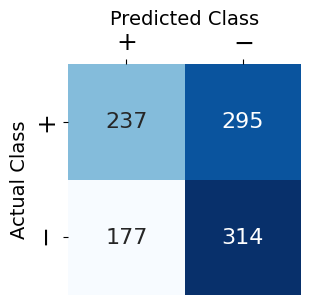

In [104]:
cm = confusion_matrix(y2_test, y2_pred_under, labels = [1, 0])
plot_confusion_mtx(cm, [], binary = True)

---

In [105]:
param = {'min_samples_leaf': list(range(5, 25)),
         'max_leaf_nodes': list(range(4, 11))}


grid_search = GridSearchCV(DTC(random_state = 5),
                           param_grid = param, cv = LeaveOneOut(),
                           n_jobs = -1,
                           scoring = 'accuracy')

In [106]:
grid_search.fit(X2_under_res, y2_under_res)

KeyboardInterrupt: ignored

In [ ]:
# report(grid_search.cv_results_)

In [ ]:
dtc_under_tuned = grid_search.best_estimator_
dtc_under_tuned

In [ ]:
dtc_under_tuned.get_params()

In [ ]:
dtc_under_tuned.get_depth()

In [ ]:
dtc_under_tuned.get_n_leaves()

In [ ]:
y2_pred_under_tuned = dtc_under_tuned.predict(X2_test)

print(classification_report(y2_test, y2_pred_under))

In [ ]:
cm = confusion_matrix(y2_test, y2_pred_under_tuned, labels = [1, 0])
plot_confusion_mtx(cm, [], binary = True)

The random undersampling technique produces better results comparing to SMOTE, in spite of the vary small train set. This might depend on three factors: the test set is balanced; the undersampling technique does not produce artificial instances; WALKING DOWNSTAIRS and UPSTAIRS are well distinguish activities and the classifier does not need many instances to build a reliable model.

### TOMEK LINKS

In [107]:
!pip install imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.tree import DecisionTreeClassifier

Accuracy 0.5855327468230694
F1-score [0.34769231 0.69627507]
              precision    recall  f1-score   support

           0       0.71      0.23      0.35       491
           1       0.56      0.91      0.70       532

    accuracy                           0.59      1023
   macro avg       0.64      0.57      0.52      1023
weighted avg       0.63      0.59      0.53      1023



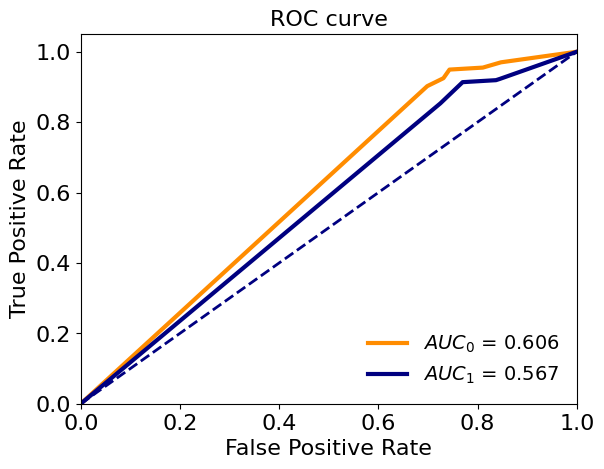

In [108]:
tl = TomekLinks()
X_res, y_res = tl.fit_resample(X2_train_imb, y2_train_imb)

clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_res, y_res)

y_pred = clf.predict(X2_test)

print('Accuracy %s' % accuracy_score(y2_test, y_pred))
print('F1-score %s' % f1_score(y2_test, y_pred, average=None))
print(classification_report(y2_test, y_pred))

y_score = clf.predict_proba(X2_test)
fpr, tpr, _ = roc_curve(y2_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='navy', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

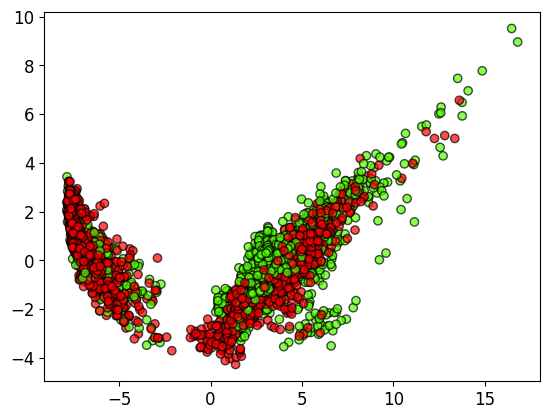

In [109]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X2_train)
X_pca = pca.transform(X2_train)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y2_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

In [110]:
from sklearn.manifold import MDS, TSNE, Isomap

In [111]:
iso = Isomap(n_neighbors = 4, n_components = 2, n_jobs = -1)
X_train_iso = iso.fit_transform(X2_train)
X_test_iso = iso.transform(X2_test)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.10/dist-packages

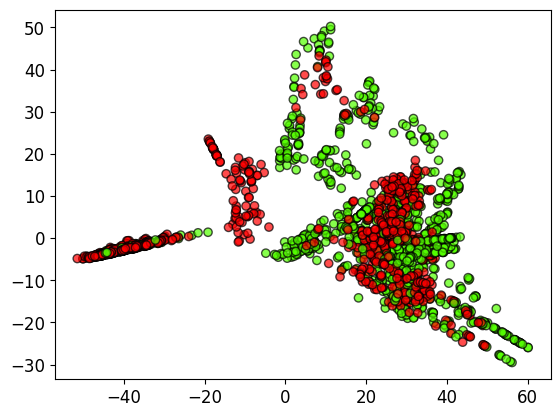

In [113]:
plt.scatter(X_train_iso[:, 0], X_train_iso[:, 1], c=y2_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

In [114]:
mds = MDS(n_components = 2, random_state = 5)
X_train_mds = mds.fit_transform(X2_train)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


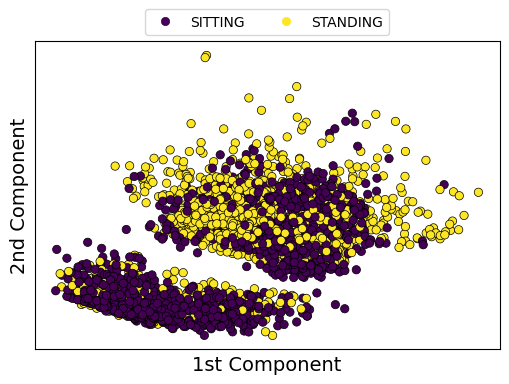

In [118]:
plot_scatter(X_train_mds, y2_train, activities)
# plt.savefig('mds_2d.pdf', bbox_inches = 'tight')
plt.show()

### CNN

1. Get all minority samples in a set C.

2. Add a sample from the targeted class (class to be under-sampled) in C and all other samples of this class in a set S.

3. Go through the set S, sample by sample, and classify each sample using a 1 nearest neighbor rule.

4. If the sample is misclassified, add it to C, otherwise do nothing.

5. Reiterate on S until there is no samples to be added.

In [119]:
cnn = CNN(random_state = 5, n_jobs = -1)
X_cnn_res, y_cnn_res = cnn.fit_resample(X2_train_imb, y2_train_imb.values)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({1: 1368, 0: 41})


In [ ]:
np.unique(y_cnn_res, return_counts = True)

(array([0, 1], dtype=int64), array([37, 44], dtype=int64))

Accuracy 0.6549364613880743
F1-score [0.59001161 0.7021097 ]
              precision    recall  f1-score   support

           0       0.69      0.52      0.59       491
           1       0.64      0.78      0.70       532

    accuracy                           0.65      1023
   macro avg       0.66      0.65      0.65      1023
weighted avg       0.66      0.65      0.65      1023



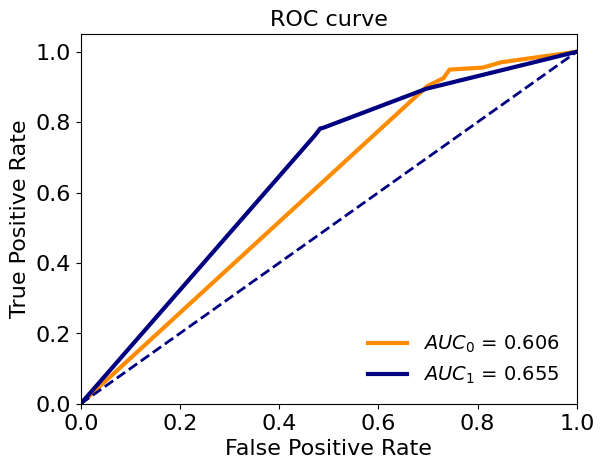

In [122]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_cnn_res, y_cnn_res)

y_pred = clf.predict(X2_test)

print('Accuracy %s' % accuracy_score(y2_test, y_pred))
print('F1-score %s' % f1_score(y2_test, y_pred, average=None))
print(classification_report(y2_test, y_pred))

y_score = clf.predict_proba(X2_test)
fpr, tpr, _ = roc_curve(y2_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='navy', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()


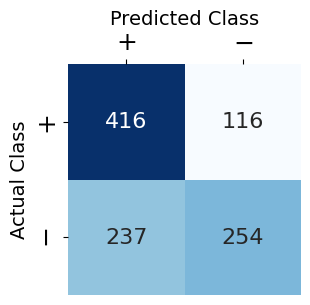

In [129]:
cm = confusion_matrix(y2_test, y_pred, labels = [1, 0])
plot_confusion_mtx(cm, [], binary = True)

The CNN does not always produce class with the same cardinality

## OVERSAMPLING

In [130]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

Accuracy 0.5043988269794721
F1-score [0.19138756 0.64270613]
              precision    recall  f1-score   support

           0       0.44      0.12      0.19       491
           1       0.51      0.86      0.64       532

    accuracy                           0.50      1023
   macro avg       0.48      0.49      0.42      1023
weighted avg       0.48      0.50      0.43      1023



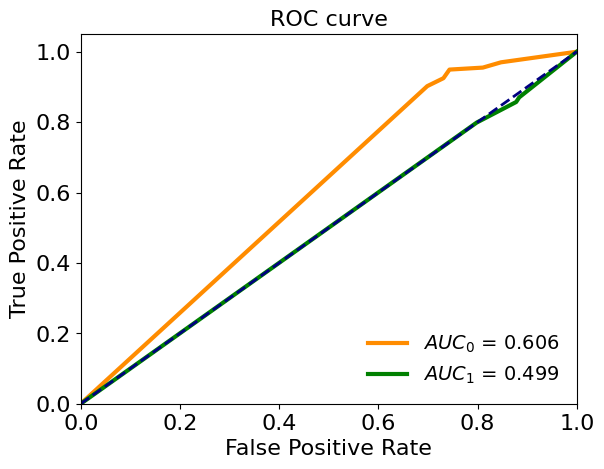

In [132]:
ada = ADASYN(random_state=42)
X_ada_res, y_ada_res = ada.fit_resample(X2_train_imb, y2_train_imb)

clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_ada_res, y_ada_res)

y_pred = clf.predict(X2_test)

print('Accuracy %s' % accuracy_score(y2_test, y_pred))
print('F1-score %s' % f1_score(y2_test, y_pred, average=None))
print(classification_report(y2_test, y_pred))

y_score = clf.predict_proba(X2_test)
fpr, tpr, _ = roc_curve(y2_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [134]:
np.unique(y_ada_res, return_counts = True)

(array([0, 1]), array([1367, 1373]))

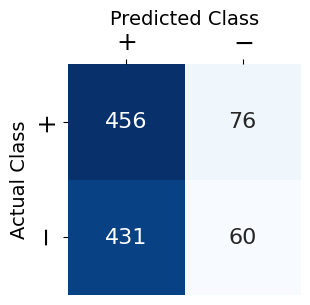

In [135]:
cm = confusion_matrix(y2_test, y_pred, labels = [1, 0])
plot_confusion_mtx(cm, [], binary = True)

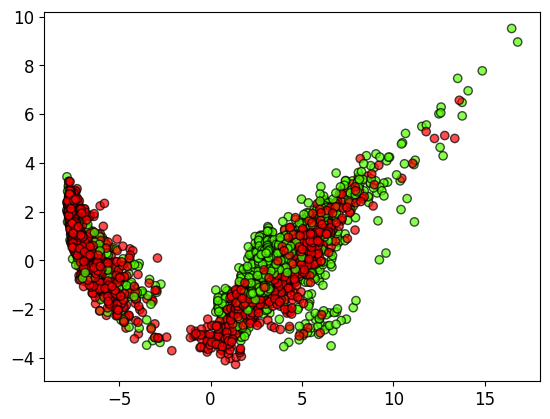

In [140]:
pca = PCA(n_components=2)
pca.fit(X2_train)
X_pca = pca.transform(X2_train)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y2_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()


The bad performances of CNN with hyperparameter tuning might depend on the small cardinality of the training set. Indeed, the parameter ranges are not compatible with only 44 records.

### RANDOM OVER SAMPLER

In [141]:
ros = RandomOverSampler(random_state=42)
X_ran_res, y_ran_res = ros.fit_resample(X2_train, y2_train)
print('Resampled dataset shape %s' % Counter(y_ran_res))

Resampled dataset shape Counter({5: 1373, 4: 1373})


Accuracy 0.0
F1-score [0. 0. 0. 0.]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     491.0
           1       0.00      0.00      0.00     532.0
           4       0.00      0.00      0.00       0.0
           5       0.00      0.00      0.00       0.0

    accuracy                           0.00    1023.0
   macro avg       0.00      0.00      0.00    1023.0
weighted avg       0.00      0.00      0.00    1023.0



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

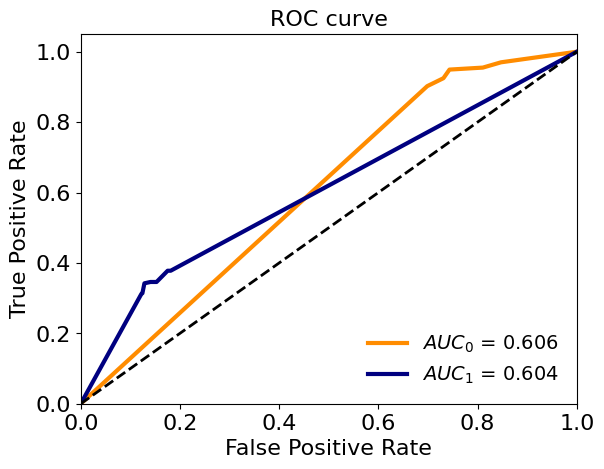

In [148]:
clf3 = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf3.fit(X_ran_res, y_ran_res)

y_pred_2 = clf3.predict(X2_test)

print('Accuracy %s' % accuracy_score(y2_test, y_pred_2))
print('F1-score %s' % f1_score(y2_test, y_pred_2, average=None))
print(classification_report(y2_test, y_pred_2))

y_score = clf3.predict_proba(X2_test)
fpr, tpr, _ = roc_curve(y2_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='navy', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

### SMOTE

In [146]:
sm = SMOTE(random_state=42)
X_SMO_res, y_SMO_res = sm.fit_resample(X2_train, y2_train)
print('Resampled dataset shape %s' % Counter(y_SMO_res))

Resampled dataset shape Counter({5: 1373, 4: 1373})


Accuracy 0.0
F1-score [0. 0. 0. 0.]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     491.0
           1       0.00      0.00      0.00     532.0
           4       0.00      0.00      0.00       0.0
           5       0.00      0.00      0.00       0.0

    accuracy                           0.00    1023.0
   macro avg       0.00      0.00      0.00    1023.0
weighted avg       0.00      0.00      0.00    1023.0



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

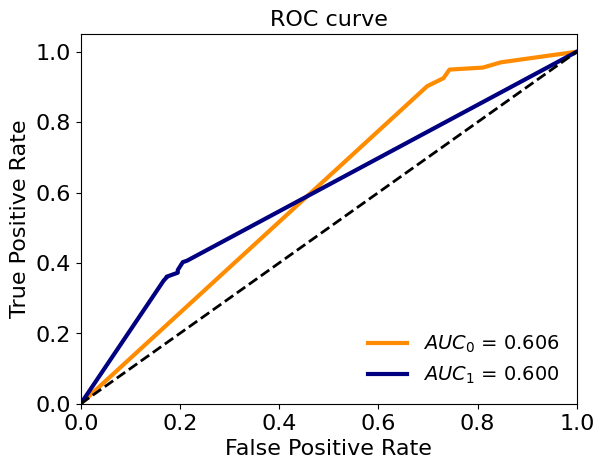

In [147]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_SMO_res, y_SMO_res)

y_pred_SMO = clf.predict(X2_test)

print('Accuracy %s' % accuracy_score(y2_test, y_pred_SMO))
print('F1-score %s' % f1_score(y2_test, y_pred_SMO, average=None))
print(classification_report(y2_test, y_pred_SMO))

y_score = clf.predict_proba(X2_test)
fpr, tpr, _ = roc_curve(y2_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='navy', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

### EDITED NEAREST NEIGHBOR

In [149]:
enn = ENN(n_neighbors = 10, n_jobs = -1)
X2_enn_res, y2_enn_res = enn.fit_resample(X2_train_imb, y2_train_imb)

In [150]:
np.unique(y2_enn_res, return_counts = True)

(array([0, 1]), array([  41, 1183]))

In [151]:
np.unique(y2_train_imb, return_counts = True)

(array([0, 1]), array([  41, 1373]))

Accuracy 0.5288367546432062
F1-score [0.20723684 0.66481224]
              precision    recall  f1-score   support

           0       0.54      0.13      0.21       491
           1       0.53      0.90      0.66       532

    accuracy                           0.53      1023
   macro avg       0.53      0.51      0.44      1023
weighted avg       0.53      0.53      0.45      1023



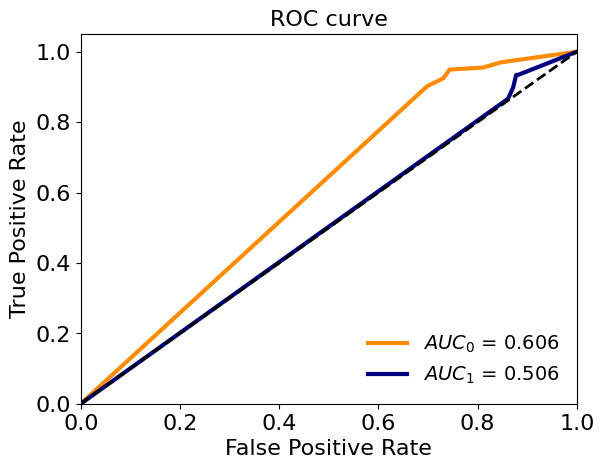

In [152]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X2_enn_res, y2_enn_res)

y_pred_ENN = clf.predict(X2_test)

print('Accuracy %s' % accuracy_score(y2_test, y_pred_ENN))
print('F1-score %s' % f1_score(y2_test, y_pred_ENN, average=None))
print(classification_report(y2_test, y_pred_ENN))

y_score = clf.predict_proba(X2_test)
fpr, tpr, _ = roc_curve(y2_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='navy', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

## COMBINATION

### SMOTETOMEK

In order to prevent some kind of loose of information or something like that, during the sampling movement of the data, we performe also a combination of a Undersampling-Oversampling tecnique for appreciate the results

In [ ]:
smote_tomek = SMOTETomek(random_state = 5, n_jobs = -1)
X_smote_tomek_res, y_smote_tomek_res = smote_tomek.fit_resample(X2_train_imb, y2_train_imb)

In [ ]:
np.unique(y_smote_tomek_res, return_counts = True)

(array([0, 1], dtype=int64), array([1070, 1070], dtype=int64))

In [195]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_smote_tomek_res, y_smote_tomek_res)

y_pred_ENN = clf.predict(X2_test)

print('Accuracy %s' % accuracy_score(y2_test, y_pred_ENN))
print('F1-score %s' % f1_score(y2_test, y_pred_ENN, average=None))
print(classification_report(y2_test, y_pred_ENN, target_names=activities.values()))

y_score = clf.predict_proba(X2_test)
fpr, tpr, _ = roc_curve(y2_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='navy', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

NameError: ignored

As for the TomekLinks, the SMOTETomek does not find any Tomek link after the SMOTE step. Therefore, it produces the same results of the plain SMOTE.

##### SMOTEENN

In [183]:
enn = ENN(sampling_strategy = 'all', n_neighbors = 5, n_jobs = -1)
smoteenn = SMOTEENN(sampling_strategy = 'all', enn = enn,
                    random_state = 5, n_jobs = -1)
X_smoteenn_res, y_smote_smoteenn_res = smoteenn.fit_resample(X2_train_imb, y2_train_imb)

/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [184]:
np.unique(y_smote_smoteenn_res, return_counts = True)

(array([0, 1]), array([1373,  994]))

In [185]:
# CNN, w tuning

param = {'max_depth': list(range(3,11)),
         'min_samples_leaf': list(range(10, 41, 5)),
         'max_leaf_nodes': list(range(5, 31, 5))}

grid_search = GridSearchCV(DTC(random_state = 5),
                           param_grid = param, cv = 5,
                           n_jobs = -1,
                           scoring = 'accuracy')

In [186]:
grid_search.fit(X_smoteenn_res, y_smote_smoteenn_res)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=5), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                         'max_leaf_nodes': [5, 10, 15, 20, 25, 30],
                         'min_samples_leaf': [10, 15, 20, 25, 30, 35, 40]},
             scoring='accuracy')

In [187]:
# report(grid_search.cv_results_)

In [188]:
dtc_smoteen_tuned = grid_search.best_estimator_
dtc_smoteen_tuned

DecisionTreeClassifier(max_depth=9, max_leaf_nodes=20, min_samples_leaf=10,
                       random_state=5)

In [189]:
dtc_smoteen_tuned.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 9,
 'max_features': None,
 'max_leaf_nodes': 20,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 5,
 'splitter': 'best'}

In [190]:
dtc_smoteen_tuned.get_depth()

9

In [191]:
dtc_smoteen_tuned.get_n_leaves()

20

In [192]:
y2_smoteenn_pred = grid_search.predict(X2_test)

In [193]:
print(classification_report(y2_test, y2_smoteenn_pred))

              precision    recall  f1-score   support

           0       0.50      0.52      0.51       491
           1       0.54      0.53      0.54       532

    accuracy                           0.52      1023
   macro avg       0.52      0.52      0.52      1023
weighted avg       0.52      0.52      0.52      1023



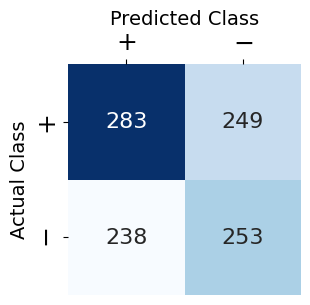

In [194]:
cm = confusion_matrix(y2_test, y2_smoteenn_pred, labels = [1, 0])
plot_confusion_mtx(cm, [], binary = True)

Results are better than to the plain SMOTE. However, the results of the two methods are note completely comparable since smoteen does not perform the same smote of the plain smote because of randomness.

Observation: we already saw that the 1st-NN of each object is 99% of times an object belonging to the same class. Since all the tested undersampling techniques based upon the NN perform bad (they remove almost all the records in CNN, whereas they does not remove anything in TomekLinks and ENN) this might mean that even the 2nd, 3th etc. NN of each object belong to the same class. In this scenario, the KNN classifier should have very good results.

##### ADASYN

In [ ]:
# we only preform the oversamplig of the minority class

adasyn = ADASYN(random_state = 5, n_neighbors = 3,
                sampling_strategy = 'minority', n_jobs = -1)
X3_adasyn_res, y3_adasyn_res = adasyn.fit_resample(X3_train_res, y3_train_res)

In [ ]:
np.unique(y3_adasyn_res, return_counts = True)

(array([1, 2, 3, 4, 5, 6], dtype=int64),
 array([1225, 1070, 1373, 1277, 1373, 1378], dtype=int64))

In [ ]:
# ADASYN, w/o tuning

dtc_adasyn_multi = DTC(random_state = 5).fit(X3_adasyn_res, y3_adasyn_res)

In [ ]:
dtc_adasyn_multi.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 5,
 'splitter': 'best'}

In [ ]:
dtc_adasyn_multi.get_depth()

20

In [ ]:
dtc_adasyn_multi.get_n_leaves()

162

In [ ]:
y3_pred_adasyn = dtc_adasyn_multi.predict(X_test)

print(classification_report(y_test, y3_pred_adasyn,
                           target_names = activities.values()))

                    precision    recall  f1-score   support

           WALKING       0.76      0.97      0.85       496
  WALKING_UPSTAIRS       0.68      0.84      0.75       471
WALKING_DOWNSTAIRS       0.95      0.38      0.54       420
           SITTING       0.82      0.75      0.78       491
          STANDING       0.78      0.84      0.81       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.81      2947
         macro avg       0.83      0.80      0.79      2947
      weighted avg       0.83      0.81      0.80      2947



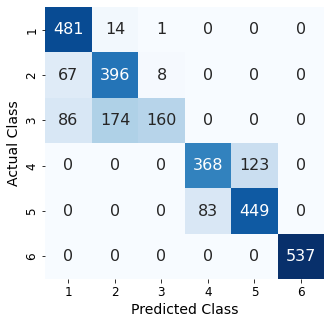

In [ ]:
cm = confusion_matrix(y_test, y3_pred_adasyn, labels = clf.classes_)
plot_confusion_mtx(cm, clf.classes_, figsize = (5, 5), binary = False)

In [ ]:
param = {'max_depth': list(range(3,11)),
         'min_samples_leaf': list(range(10, 41, 5)),
         'max_leaf_nodes': list(range(5, 31, 5))}

grid_search = GridSearchCV(DTC(random_state = 5),
                           param_grid = param, cv = 5,
                           n_jobs = -1,
                           scoring = 'accuracy')

In [ ]:
grid_search.fit(X3_adasyn_res, y3_adasyn_res)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=5), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                         'max_leaf_nodes': [5, 10, 15, 20, 25, 30],
                         'min_samples_leaf': [10, 15, 20, 25, 30, 35, 40]},
             scoring='accuracy')

In [ ]:
dtc_adasyn_multi_tuned = grid_search.best_estimator_
dtc_adasyn_multi_tuned

DecisionTreeClassifier(max_depth=8, max_leaf_nodes=25, min_samples_leaf=20,
                       random_state=5)

In [ ]:
dtc_adasyn_multi_tuned.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 8,
 'max_features': None,
 'max_leaf_nodes': 25,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 20,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 5,
 'splitter': 'best'}

In [ ]:
dtc_adasyn_multi_tuned.get_depth()

7

In [ ]:
dtc_adasyn_multi_tuned.get_n_leaves()

25

In [ ]:
y3_adasyn_pred = dtc_adasyn_multi_tuned.predict(X_test)
print(classification_report(y_test, y3_adasyn_pred,
                           target_names = activities.values()))

                    precision    recall  f1-score   support

           WALKING       0.78      0.93      0.84       496
  WALKING_UPSTAIRS       0.67      0.85      0.75       471
WALKING_DOWNSTAIRS       0.92      0.44      0.60       420
           SITTING       0.90      0.68      0.77       491
          STANDING       0.76      0.93      0.83       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.82      2947
         macro avg       0.84      0.80      0.80      2947
      weighted avg       0.84      0.82      0.81      2947



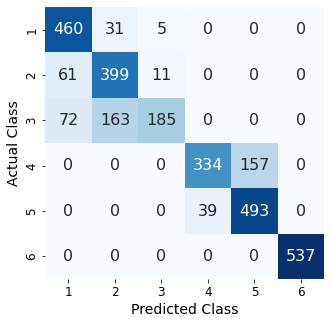

In [ ]:
cm = confusion_matrix(y_test, y3_adasyn_pred, labels = grid_search.classes_)
plot_confusion_mtx(cm, grid_search.classes_, figsize = (5, 5), binary = False)

##### CNN

In [ ]:
cnn = CNN(random_state = 5, n_jobs = -1)
X3_cnn_res, y3_cnn_res = cnn.fit_resample(X3_train_res, y3_train_res)

In [ ]:
y3_cnn_res.value_counts()

3    50
2    34
1    27
4     6
5     5
6     4
Name: 0, dtype: int64

In [ ]:
dtc_multi_cnn = DTC(random_state = 5).fit(X3_cnn_res, y3_cnn_res)

In [ ]:
dtc_multi_cnn.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 5,
 'splitter': 'best'}

In [ ]:
dtc_multi_cnn.get_depth()

7

In [ ]:
dtc_multi_cnn.get_n_leaves()

21

In [ ]:
y3_cnn_pred = dtc_multi_cnn.predict(X_test)

print(classification_report(y_test, y3_cnn_pred,
                           target_names = activities.values()))

                    precision    recall  f1-score   support

           WALKING       0.53      0.76      0.62       496
  WALKING_UPSTAIRS       0.71      0.74      0.73       471
WALKING_DOWNSTAIRS       0.92      0.73      0.81       420
           SITTING       0.76      0.63      0.69       491
          STANDING       0.71      0.73      0.72       532
            LAYING       0.95      0.79      0.86       537

          accuracy                           0.73      2947
         macro avg       0.76      0.73      0.74      2947
      weighted avg       0.76      0.73      0.74      2947



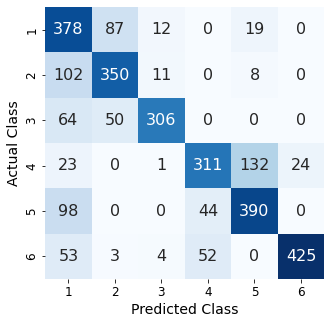

In [ ]:
cm = confusion_matrix(y_test, y3_cnn_pred, labels = clf.classes_)
plot_confusion_mtx(cm, clf.classes_, figsize = (5, 5), binary = False)

In [ ]:
param = {'min_samples_leaf': list(range(1, 25)),
         'max_leaf_nodes': list(range(1,11))}

grid_search = GridSearchCV(DTC(random_state = 5),
                           param_grid = param, cv = LeaveOneOut(),
                           n_jobs = -1,
                           scoring = 'f1_weighted')

In [ ]:
grid_search.fit(X3_cnn_res, y3_cnn_res)

C:\Users\simon\anaconda3\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
3024 fits failed out of a total of 30240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3024 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\simon\anaconda3\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\simon\anaconda3\envs\myenv\lib\site-packages\sklearn\tree\_classes.py", line 937, in fit
    super().fit(
  File "C:\Users\simon\anaconda3\envs\myenv\lib\site-packages\sklearn\tree\_classes.py", line 314, in fit
    raise ValueError(
ValueError: max_leaf_nodes 1 m

GridSearchCV(cv=LeaveOneOut(), estimator=DecisionTreeClassifier(random_state=5),
             n_jobs=-1,
             param_grid={'max_leaf_nodes': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24]},
             scoring='f1_weighted')

In [ ]:
y3_cnn_pred = grid_search.predict(X_test)

print(classification_report(y_test, y3_cnn_pred,
                           target_names = activities.values()))

                    precision    recall  f1-score   support

           WALKING       0.48      0.76      0.59       496
  WALKING_UPSTAIRS       0.69      0.64      0.66       471
WALKING_DOWNSTAIRS       0.94      0.72      0.81       420
           SITTING       0.39      0.68      0.50       491
          STANDING       0.71      0.73      0.72       532
            LAYING       0.00      0.00      0.00       537

          accuracy                           0.58      2947
         macro avg       0.53      0.59      0.55      2947
      weighted avg       0.52      0.58      0.53      2947



C:\Users\simon\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\simon\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\simon\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


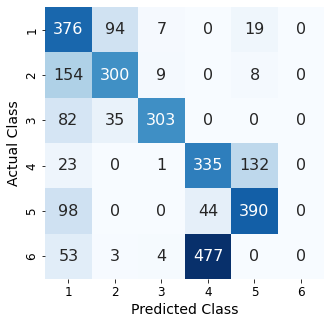

In [ ]:
cm = confusion_matrix(y_test, y3_cnn_pred, labels = grid_search.classes_)
plot_confusion_mtx(cm, grid_search.classes_, figsize = (5, 5), binary = False)

### RANDOM UNDERSAMPLING

In [ ]:
under = RUS(sampling_strategy = 'not minority', random_state = 5)
X3_under_res, y3_under_res = under.fit_resample(X3_train_res, y3_train_res)

In [ ]:
y3_under_res.value_counts()

1    50
2    50
3    50
4    50
5    50
6    50
Name: 0, dtype: int64

In [ ]:
# CNN, w tuning

param = {'max_depth': list(range(3,11)),
         'min_samples_leaf': list(range(10, 41, 5)),
         'max_leaf_nodes': list(range(5, 31, 5))}

grid_search = GridSearchCV(DTC(random_state = 5),
                           param_grid = param, cv = 5,
                           n_jobs = -1,
                           scoring = 'accuracy')

In [ ]:
grid_search.fit(X3_under_res, y3_under_res)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=5), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                         'max_leaf_nodes': [5, 10, 15, 20, 25, 30],
                         'min_samples_leaf': [10, 15, 20, 25, 30, 35, 40]},
             scoring='accuracy')

In [ ]:
dtc_multi_und = grid_search.best_estimator_

In [ ]:
dtc_multi_und.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': 10,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 35,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 5,
 'splitter': 'best'}

In [ ]:
dtc_multi_und.get_depth()

4

In [ ]:
dtc_multi_und.get_n_leaves()

6

In [ ]:
y3_under_pred = dtc_multi_und.predict(X_test)

print(classification_report(y_test, y3_under_pred,
                           target_names = activities.values()))

                    precision    recall  f1-score   support

           WALKING       0.84      0.75      0.79       496
  WALKING_UPSTAIRS       0.70      0.91      0.79       471
WALKING_DOWNSTAIRS       0.91      0.73      0.81       420
           SITTING       0.79      0.81      0.80       491
          STANDING       0.82      0.80      0.81       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.84      2947
         macro avg       0.84      0.83      0.83      2947
      weighted avg       0.84      0.84      0.84      2947



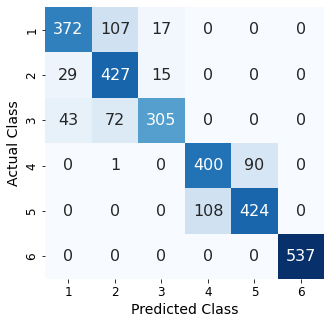

In [ ]:
cm = confusion_matrix(y_test, y3_under_pred, labels = grid_search.classes_)
plot_confusion_mtx(cm, grid_search.classes_, figsize = (5, 5), binary = False)